In [11]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn import svm
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,AdaBoostRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.inspection import permutation_importance
import pickle

# Fetching and preparing data 

In [12]:
# features = pd.read_csv('../data/features.csv', index_col= 0)
features = pd.read_csv('../data/features_with_vars.csv', index_col=0)

# Uncomment desired rating mode
# ratings = pd.read_csv('../data/average_ratings.csv',index_col = 0)
ratings = pd.read_csv('../data/average_ratings_no_outliers.csv',index_col = 0)

In [13]:
# uncomment the line below if you are using features.csv instead of features_with_vars.csv
# features_reduced  = features.iloc[:,2:-6]
# comment the line below if you are using features.csv instead of features_with_vars.csv
features_reduced = features.iloc[:,2:-1] 

X = features_reduced.values

y = ratings.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


array_of_accuracies = {}

# Linear Regression

In [14]:
# Training model
linear_regression_model = LinearRegression()
reg = linear_regression_model.fit(X_train, y_train) 

In [15]:
# Evaluating model
reg_y_pred = reg.predict(X_test)
acc_mse = mean_squared_error(reg_y_pred,y_test)
print(mean_squared_error(reg_y_pred,y_test))

array_of_accuracies["Linear Regression"] = acc_mse


0.38816686631751546


In [16]:
# save the model to disk
filename = 'linear_model.sav'
pickle.dump(reg, open(filename, 'wb'))

# Support Vector Machines

In [17]:
# Training svm model with rbf kernel
SVM = svm.SVR()

# SVM HyperParameter Tuning
K = 10

# specifying list of parameters to be searched over
max_iter_int = -1
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = [2,4,6,8,10]
tolfloat = 1e-5

# creating variables that will keep track of best score and parameters
best_score = 10
hp = {"kernel" : kernel[0], "degree" : 0}
counter = 1

# looping over said parameters
for j in kernel:
    count = 0
    for k in degree:    
        # creating rf with the parameters and then getting the cross val score for it
        if(j == "poly" or count == 0):
            svm_reg = svm.SVR(kernel = j, degree = k)
            score = cross_val_score(svm_reg,X_train,y_train,cv = K, scoring = "neg_mean_squared_error")
            # storing the param if they show improvements
            if(abs(np.mean(score)) < best_score):
                best_score = abs(np.mean(score))
                hp = {"kernel" : j, "degree": k}

            counter+=1    
            count += 1

In [18]:
# Assigning the best hyperparameters to hp_svm_reg
hp_svm_reg = hp

# creating the svm_reg based on those parameters
svm_reg = svm.SVR(kernel = hp_svm_reg["kernel"], degree = hp_svm_reg["degree"])
svm_reg.fit(X_train,y_train)

# using svm_reg to evaluate the test set
svm_y_pred = svm_reg.predict(X_test)

# getting the accuracy of the prediction
acc_mse = mean_squared_error(svm_y_pred,y_test)
print(acc_mse)

array_of_accuracies["SVM"] = (acc_mse)

0.6526038867511781


# Random Forests 

In [19]:
K = 10

# specifying list of parameters to be searched over
max_d = [1,2,3,4,5]
max_f = ["sqrt","log2","auto"]
estimators = np.linspace(10,400,5)

# creating variables that will keep track of best score and parameters
best_score = 10
hp = {"max_depth" : max_d[0], "max_features": max_f[0], "n_estimators": int(estimators[0])}
counter = 1

# looping over said parameters
for j in max_d:
    for k in max_f:
        for l in estimators:
            
            # creating rf with the parameters and then getting the cross val score for it
            rf = RandomForestRegressor(random_state=123, n_estimators = int(l),max_features = k,max_depth = j)
            score = cross_val_score(rf,X_train,y_train,cv = K, scoring = "neg_mean_squared_error")
            
            # storing the param if they show improvements
            if(abs(np.mean(score)) < best_score):
                best_score = abs(np.mean(score))
                hp = {"max_depth" : j, "max_features": k, "n_estimators": int(l)}
#             print(abs((np.mean(score))))
#             print(counter)
            counter+=1                        

In [20]:
# print the best params found from the previous snippet
hp_rf = hp

# Evaluating model
rf = RandomForestRegressor(random_state=123,n_estimators = hp_rf["n_estimators"], max_features = hp_rf["max_features"]
                           , max_depth = hp_rf["max_depth"])

# fit the model on the training data
rf.fit(X_train,y_train)

# use the model to predict the test set
rf_y_pred = rf.predict(X_test)
acc_mse = mean_squared_error(rf_y_pred,y_test)

print(acc_mse)

array_of_accuracies["Random Forest"] = (acc_mse)

0.4552730279559924


# Ada Boost

In [21]:
# Basic RF model better than linear regression
K = 10

# specifying list of parameters to be searched over
lr = np.linspace(0.01,1,10)
estimators = np.linspace(10,400,5)
alg = ["SAMME","SAMME.R"]

# creating variables that will keep track of best score and parameters
best_score = 10
hp = {"learning_rate" : 0.01, "algorithm": "SAMME", "n_estimators": int(estimators[0])}
counter = 1

# looping over said parameters
for j in lr:
    for l in estimators:

        # creating rf with the parameters and then getting the cross val score for it
        ab = AdaBoostRegressor(random_state=123, n_estimators = int(l),learning_rate = j)
        score = cross_val_score(ab,X_train,y_train,cv = K, scoring = "neg_mean_squared_error")

        # storing the param if they show improvements
        if(abs(np.mean(score)) < best_score):
            best_score = abs(np.mean(score))
            hp = {"learning_rate" : j, "n_estimators": int(l)}
        counter+=1  
        
k = 10
ab = AdaBoostRegressor(random_state=123)
score = cross_val_score(ab,X_train,y_train,cv = k)

In [27]:
# Assigning the best hyperparameters to hp_ab
hp_ab = hp

# Creating hp_ab based on the best hyperparameters
ab = AdaBoostRegressor(random_state=123, n_estimators = hp_ab["n_estimators"],learning_rate = hp_ab["learning_rate"])

# fitting the model
ab.fit(X_train,y_train)

# using the model to make prediction on the test set
ab_y_pred = ab.predict(X_test)

acc_mse = mean_squared_error(ab_y_pred,y_test)
print(acc_mse)

array_of_accuracies["AdaBoost"] = (acc_mse)

KeyError: 'learning_rate'

In [72]:
print(array_of_accuracies)

{'Linear Regression': 0.38434155015769855, 'Random Forest': 0.8050665935608865, 'AdaBoost': 0.40046531447686606}


# Nearest Neighboors

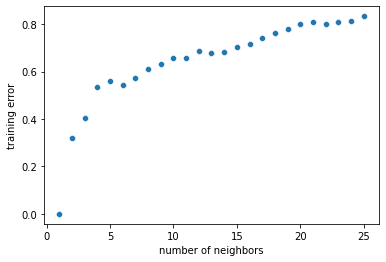

KNeighborsRegressor(n_neighbors=1)

In [16]:
counter = 0
training_error = np.zeros(25)

for i in range(1,26):
    nn = KNeighborsRegressor(n_neighbors=i)
    nn.fit(X_train, y_train)
    training_error[counter] = (mean_squared_error(nn.predict(X_train),y_train))
    counter += 1
    
x = np.linspace(1,25,25)
a = sns.scatterplot(x = x,y = training_error)
a.set(xlabel = 'number of neighbors', ylabel = 'training error')
plt.show()


nn = KNeighborsRegressor(n_neighbors = 1)
nn.fit(X_train,y_train)

In [17]:
# evaluating the model
y_test_nn = nn.predict(X_test)

acc_mse = mean_squared_error(y_test_nn,y_test)

array_of_accuracies["KNN"] = acc_mse

# Neural Net

In [81]:
regr = MLPRegressor(random_state=1, learning_rate_init = 0.01, max_iter=500).fit(X_train, y_train)

y_pred_nn = regr.predict(X_test)

acc_mse = mean_squared_error(y_pred_nn,y_test)

print(acc_mse)

array_of_accuracies["Neural Network"] = acc_mse


1.7145199022095838


# Make Plot of all the Accuracies 

In [18]:
print(array_of_accuracies.keys())
print(list(array_of_accuracies.values()))

dict_keys(['KNN'])
[1.3447636457756884]


In [ ]:
plt.figure(figsize = (9,8))
plt.ylabel('Mean Squred Error')
sns.set_context("paper", font_scale=1)
sns.set_style('whitegrid')
sns.set_style({'font.family': 'Times New Roman'})
sns.barplot(x = list(array_of_accuracies.keys()), y = list(array_of_accuracies.values()))
plt.tight_layout()

# Performing the Binary Task for Comparison with the Michigan Study

In [9]:
binary_ratings = 1*(ratings['snippet rating'].values > 5)
y = binary_ratings
X_train, X_test, y_train, y_test = train_test_split(X, binary_ratings, test_size=0.2, random_state=12)

# Logistic Regression, Random Forests, AdaBoost, SVM

In [10]:
supervised_model_classes = {
                            "Random Forest": RandomForestClassifier,
                            "AdaBoost": AdaBoostClassifier,
                            "Logistic R.": LogisticRegression,
                            "Naive Bayes": GaussianNB,
                            "Bernoulli NB": BernoulliNB
                            } 

for model_name, model_class in supervised_model_classes.items():
    fit_model = model_class().fit(X_train, y_train)
    y_pred = fit_model.predict(X_test)
    l1 = accuracy_score(y_pred, y_test)
    print(f"{model_name} \t{l1}")

Random Forest 	0.95
AdaBoost 	0.85
Logistic R. 	0.85
Naive Bayes 	0.85
Bernoulli NB 	0.75


/Users/andoliveira/miniconda3/envs/re3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
